# Face Detection 의 History

Q. Dlib 라이브러리를 이용해 Face Landmark를 찾아낼 때의 문제점은 무엇이었나요?
> * 얼굴을 잘 못 찾는다.
> * 동영상을 처리하기엔 너무 느리다.
> * 얼굴각도, 방향, 크기 등의 변화에 취약하다.
> * 그 외에도 많은 문제점을 발견할 수 있다.

* 서버를 통한 서비스는 네트워크 + 서버 + 인터넷 속도의 영향을 고려해야한다.
* 따라서 Edge device(휴대폰)의 프로세스에서 작동 가능하도록 하는 것이 유리하다.

Q. 어떻게 빠르게 만들 수 있나요?
> * Sliding window 단게를 제거해야한다.
> * 1-stage 방식의 detection을 선택한다.
> * 연산의 병렬화를 해야한다.
> * 핸드폰의 연산 병렬화를 위해, CoreML, ML kit, TFLite 등을 사용한다.

## Single stage Object Detection

* YOLO, SSD, RetinaNet 등 1-Stage Object Detection 의 발전사를 알아봅니다.

## YOLOv1의 원리 
1. You Only Look Once - 전체 이미지를 1번 본다.
2. Unifed - Localization과 Classification을 동시에 수행한다.
3. Real Time - 초당 Frame가 높아 실시간 객체를 탐지할 수 있다.
4. Object detection을 회귀 문제로 관점을 전환 했다.

### YOLO vs RCNN
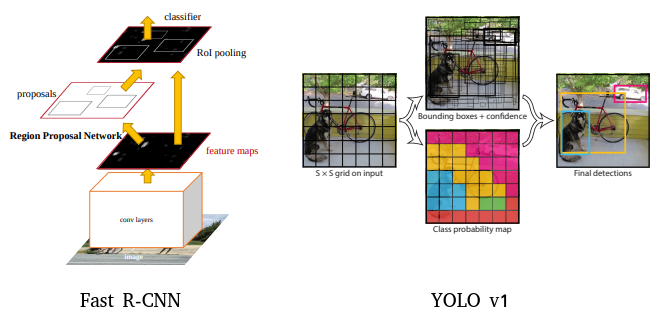

* RCNN - 객체가 존재할 것 같은 곳을 제안한다.
* YOLOv1 - Grid 안에 객체가 존재할 수 있다.

### YOLO의 gird cell

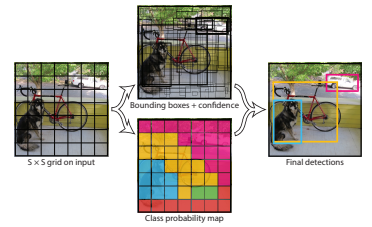

* YOLO는 grid로 나눈다음, Box regression 단계와 각 클래스의 Probaility map을 구하는 단계를 동시넹 수행한다.
* 각 grid cell은 Bounding Box와 C개의 class 확률을 예측한다.
* 각 Bounding Box는 x, y, w, h, score를 예측한다.
* 여기서 x, y는 BBox의 중심 좌표이고 w,h는 너비와 높이이다.
* 또한 w,h는 입력이미지의 크기로 normalize 한 값으로 0~1 사이의 값을 가짐
* score는 Confidence score 를 뜻하고 $P(Object) * IOU^{truth}_{pred}$ 로 박스가 예측하는 것이 얼마나 정확한지를 나타낸다.
* 위를 정리하면 하나의 grid cell은 다음과 같은 정보를 담은 tensor가 나온다.
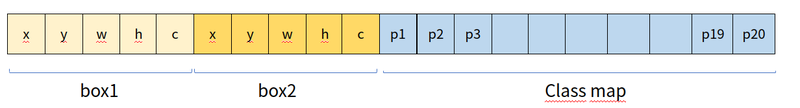

### Non-Maximum Suppression

* 여러개의 BBOx가 겹쳐 예측을 할때 정확학 BBox를 선택하는 기법
    1. 하나의 클래스에 대한 높은 confidecne score 순서대로 bbox를 정렬
    2. Confidence score가 특정 threshold를 넘지 않는 것을 제거
    3. 가장 높은 Confidence score의 bbox와 겹치는 다른 bbox들을 비교하여 IoU가 threshold 보다 높으면 더 낮은 겹친 BBox를 제거
    4. 1,2 과정을 반복하여 남은 BBox를 반환
    5. 각 클래스마다 위 과정을 반복

## YOLO 네트워크 구조

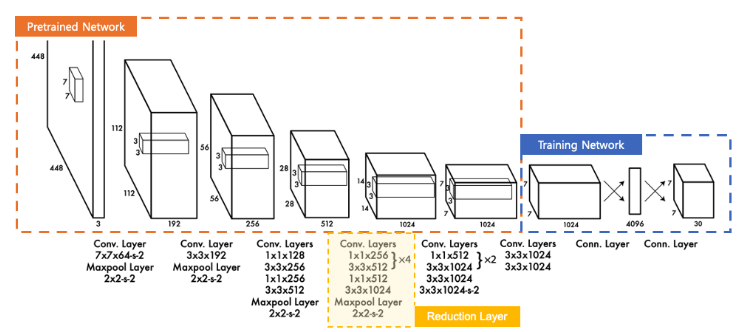

* 모델의 구조 앞부분은 GoogLeNet 을 차용
* 하지만 Inception 모듈 대신 Reduction layer를 사용하여 연산량 감소
* detection을 위해 4개의 Conv레이어, 2개의 FC레이어를 추가
* 마지막 레이어는 $S*S*(B*5+C)$ 의 크기의 텐서로 예측값이 출력

## YOLO의 Inference 과정

* 조건부 클래스 확률 $P(Class_i|Object)$ 와 각 box의 confidence 예측값과 곱해 각 box의 클래스별 confidence score를 얻을 수 있다.
* 각 score는 BBox가 클래스를 잘 예측했는지, 사물을 잘 예측했는지 보여준다.
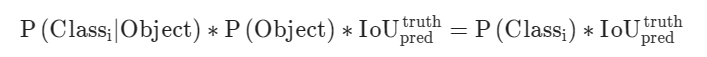
* 이 과정을 모든 BBox( 각 grid마다 2개 )에서 시행하면 $7*7*2=98$개를 얻고 여기서 NMS를 통해 최종 출력을 받는다.

## YOLOv1 성능

### Loss

* BBox의 위치 예측 - localization loss
* Class 예측 - Classification loss
* 위 두 loss를 모두 SSE(Sum-Squared error)를 기반으로 조정 가중치 추가
* BBox의 좌표 예측 loss ($\lambda_{coored}$) 가중치 증가
* 객체없음에 대한 loss ($\lambda_{noobj}$) 가중치 감소
* 박스의 크기에 따라 위치 변화에 민감함을 개선하기 위해 너비 * 높이에 square root를 취함
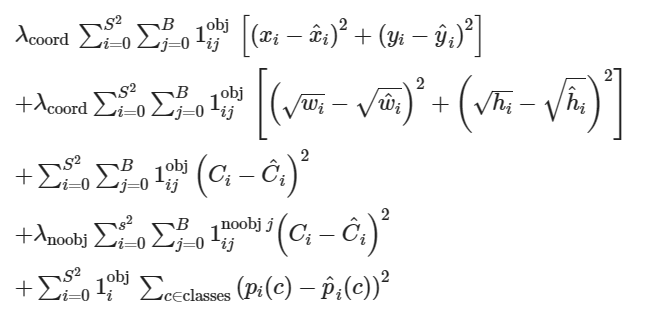

* 여기서 $1^{obj}_i$는 i 번째 grid cell 안에 객체가 있는지 없는지를 확인, 있으면 1, 없으면 0 으로 출력
* $1^{obj}_{ij}$는 객체가 존재하는 i번째 grid cell의 j번째 BBox predictor이다. 즉 i 번째 grid cell에 객체가 있고, j번째 predictor의 값이 다른 predictor보다 높으면 1, 아니면 0 으로 출력
* $1^{noobj}_{ij}$는 객체가 존재하지 않는 i번째 gird cell의 j번째 BBox predictor를 말함

* Loss 식의 줄 별로 설명을 추가하면
    1. X와 Y의 Loss 계산
    2. 너비와 높이의 Loss 계산(RSE)
    3. Confidence score의 Loss 계산
    4. 객체가 없을 때의 Loss(패널티)계산
    5. 객체가 존재하는 i번째 grid cell에 대해 조건부 클래스 확률의 Loss 계산

## YOLO의 단점

* Grid cell에 Box가 2개 밖에 없음
* 각 Box가 같은 클래스를 예측하기 때문에 여러 클래스를 예측하기는 어려움
* 작은 Object가 여러개 나올때는 제대로 예측하지 못함
* feature map을 기반으로 BBox를 예측하기 때문에 localization 이 부정확

## YOLOv2(YOLO9000)

### 다양한 기법 적용 (Make it Better)
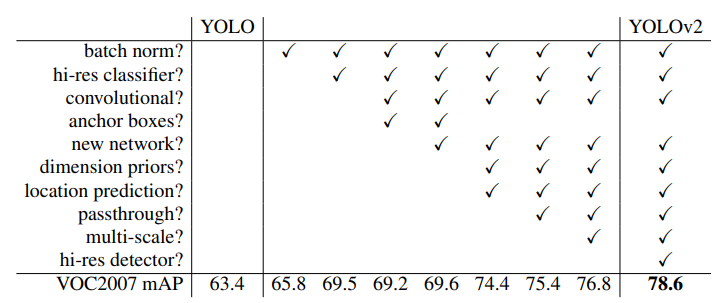
1. Batch Normalization - Dropout은 사용하지 않음
2. High Resolution Classifier - 448x448 크기의 데이터로 학습
3. Convolutional with Anchor boxes - FC layer 대신 Conv layer를 사용, Anchor box 사용
4. Dimenstion Clusters - K-means clustering을 통해 최적의 Anchor box를 결정 이때 그 IoU를 기반으로 계산, 최종적으로 5개의 anchor box를 사용
5. Direct location prediction - 중앙점을 기준으로 두지않고 좌상단에서 얼만큼 이동했는지 예측
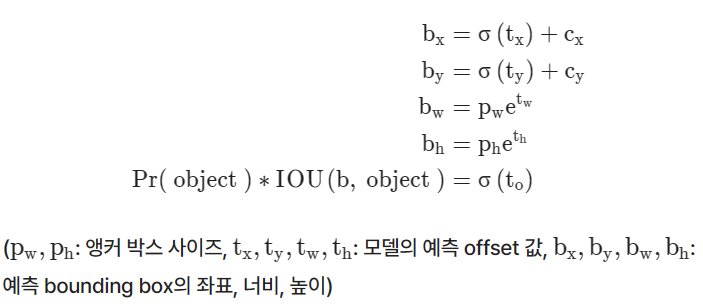
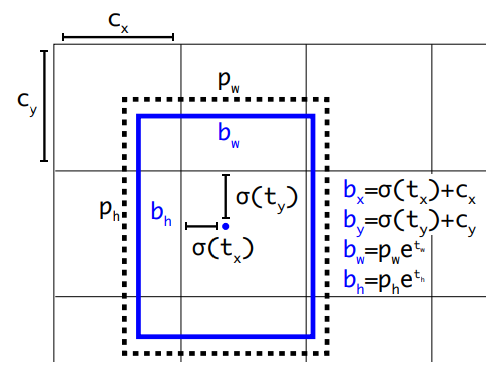
6. Fine-Grained Features (passing through) - 작은 물체를 잘 검출하지 못하던 v1의 단점을 고려, 26x26의 feature map을 13x13x4로 나눈다음 13x13의 feature map과 concatenate
7. Multi-Scale Training - 10번의 Batch마다 입력 이미지의 크기를 {32*(11~19)} 중에 하나를 사용하여 학습

### Do it faster

* FC layer를 제거하고 GAP를 사용하여 파라미터 수를 크게 줄였다.
* YOLOv2의 최종 출력은 13x13x125가 된다. 5개의 BBox * ( 4개의 좌표정보 + 1개의 Box Confidence + 20개의 Class Confidence ), 즉 $5 * 25=125$

### Makes us Stronger

* 더 많은 범위의 class를 예측
* 이는 YOLO9000과 YOLOv2에서 label 크기의 차이에서 오는것으로 YOLOv2에서는 크게 다루지 않는다.

## YOLOv3

### YOLOv3 원리

* 속도를 약간 늦추고 정확도를 개선한 모델, 특히 작은 물체를 detection하는 성능을 개선

* Bounding Box Prediction
    > * 각각의 BBox에서 물체가 있는지 예측하는 점수를 Logistic Regression을 통해 예측
    > * Anchor box와 Ground truth box의 IoU가 가장 높은 박스만 Objectness score를 1로 가지고 나머지는 무시
    
* Class Prediction
    > * 하나의 이미지에 다양한 label을 적용하여 여러개 중에서 하나만 찾는 것이 아닌 해당 label이 있는지 없는지를 판단하는 Logistic classifier, BCE를 사용하여 Loss를 계산
* Predictions Across Scales
    > * 여러 scale로 BBox를 예측, YOLOv3는 3개의 scale을 사용
    > * 각 scale은 3개의 BBox를 예측, 즉 총 9개의 BBox가 나옴
    > * 이때 텐서는 각 grid cell 마다 $3 * (4+1+80)$ 이 된다. YOLOv3는 80개의 클래스를 예측
    
* DarkNet - 53
    > * Residual을 사용하여 53개의 레이어를 사용 ( YOLOv2는 19개를 사용 )
    > 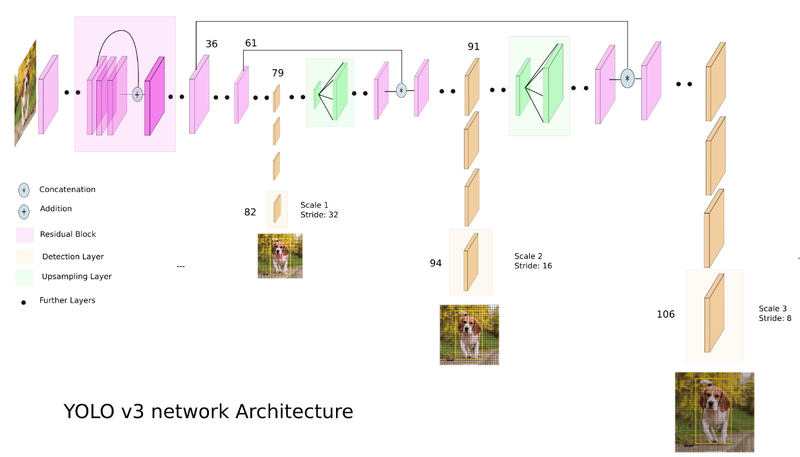
    > * 이떄 3개의 scale에서 BBox를 detection하는 것을 볼 수 있다.

## 그 이후의 YOLO

### YOLOv4

* YOLOv4 = YOLOv3+ CSPDarknet53 + SPP + PAN(Path Aggregation Network) + BoF(Bag of Freebies) + Bos(Bag of Specials)
* YOLOv4는 YOLOv3 기반으로 여러가지 기법들을 적용하여 성능을 10% 증가시켰다.
* 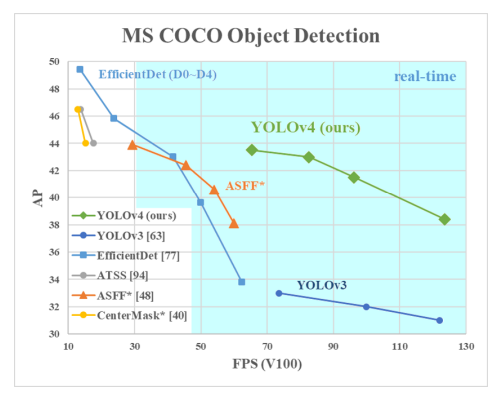

### YOLOv5

* YOLOv5 부터는 Pytorch로 구현된 YOLO이다
* YOLOv4와 비슷한 성능이지만 용량이 훨씬 작고 속도가 빠르다.
<img src="1.png" width="300" height="300">
* YOLOv5는 네트워크의 크기별 4가지 버전을 지원하는데 head는 동일하다.
* YOLOv3와 마찬가지로 3개의 scale에서 BBox를 각 3개씩 찾는다.

### PP-YOLO

* PP는 오픈소스 딥러닝 프레임워크 PaddlePaddle의 약자로 PP를 이용해 구현한 YOLO이다.
* YOLOv4와 비슷하게 YOLOv3를 기반으로 다양한 기법을 적용해 성능을 올렸다.
* YOLOv4와 달리 Backbone, Augmentation, NAS를 사용하지 않고, 더 일반적인 방법으로 성능을 개선하고자 했다.
* YOLOv3와 기본구조는 거의 동일하다. 하지만 백본으로 ResNet50-vd를 사용하고 Inject points 3가기가 추가로 적용되었다.
<center><span style="color : green">ResNet50-vd</span></center>
<img src="2.png" width="500">    
<center>(a) Stem block; (b) Stage1-Block1; (c) Stage1-Block2; (d) FC-Block</center>

* PPYOLO의 성능은 YOLOv4보다 정확도, 속도가 높다

### Scaled YOLOv4

* 다양한 디바이스 환경에서 높은 정확도로 실시간 객체 탐색이 가능한 Scaling 기술을 YOLOv4에 적용하였다.
* 여기서 앞서 YOLOv4에 CSPNet을 적용하였다.
<center><span style="color : green">CSPNet</span></center>
<img src="3.png" width="800">
* scaling의 정도로 모델을 나누었는데, CSPNet을 적용하여 P5를 만든뒤 Scale-up 하여 P6, P7을 만들었다.
<center><span style="color : green">YOLOv4-구조</span></center>
<img src="4.png" width="800">

### YOLOR ( You Only Learn One Representation )

* YOLOR은 Scaled YOLOv4 에서 파생된 모델로 저자가 같다.
* 사람이 학습할 때 명시적 지식과 암묵적 지식을 사용하는 것에서 착안하여 모델을 만들었다.
* 이때 명시적 지식은 말, 글로 표현할 수 있는 지식이고, 암묵적 지식은 경험이나 학습에 의해 체득된 지식이다
* YOLOR은 Scaled YOLOv4 모델에서 암묵적 지식을 더해주는 방식을 가진다.
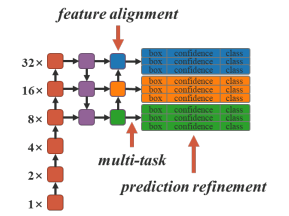

### YOLOX ( Exceeding YOLO )

* YOLOX는 Anchor-Free Detector, Advanced Label Assignment Strategy, End-to-end Detector 등 최신 연구를 YOLOv3-SPP 에 적용하였다. 특히 Decoupled Head, Strong Data Augmentation, Anchor-Free, Multi-positive를 통해 성능을 개선시키고자 했다.
    > 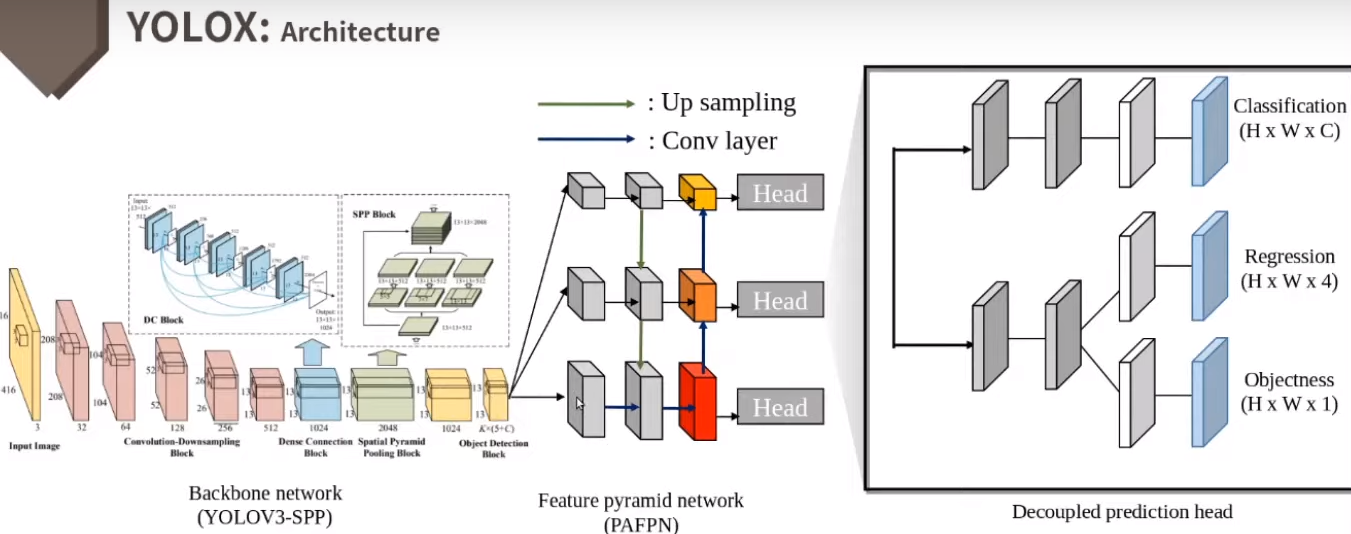
    > * YOLOv3-SPP, Backbone을 통해 Feature map을 추출
    > * FPN을 통해 Multi sacle의 Feature를 Head에 전달
* **Anchor-Free**는 Ground truth box와 Pred BBox안의 cell이 겹쳐 있으면 Positive, 아니면 Negative로 지정하여 detection을 수행하여 연상량을 낮추고, 일반화를 시키기며, Negative sample이 많아서 생기는 Class별 imabalance 문제도 해결했다고 한다.
    > 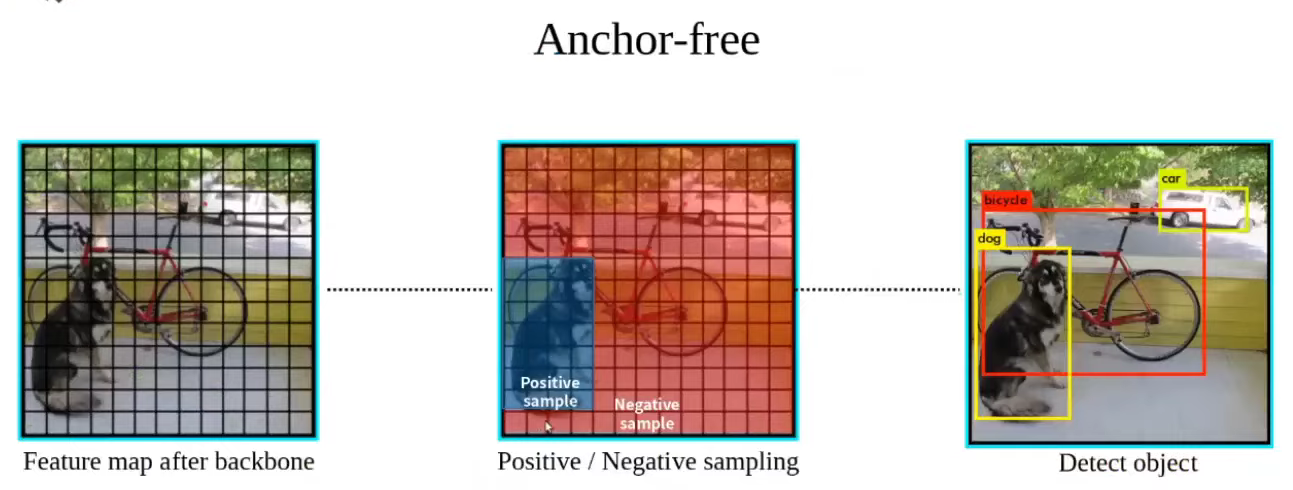
    > 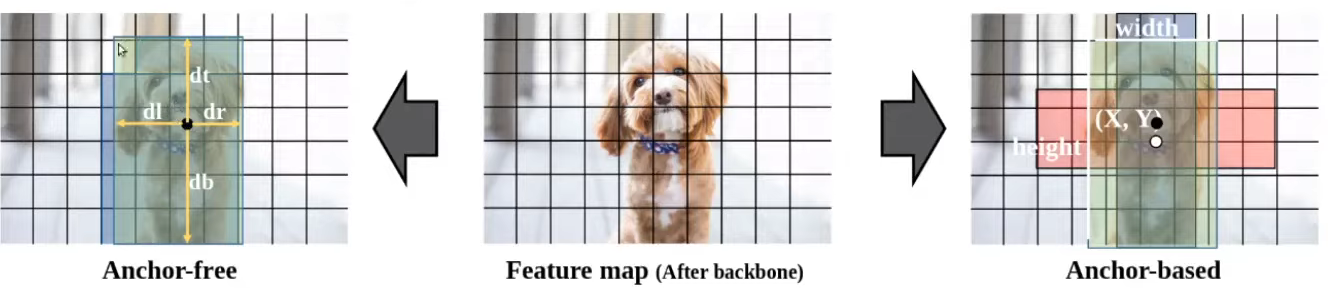
* Anchor-Free방식의 Accuaracy를 향상하기 위해 각 객체의 중심과 주변에 해당하는 cell을 Positive로 할당하여 예측하는 방법으로, **Multi-positives**를 사용하여 낮은 Loss를 가진 k개의 cell만 학습에 참여하는 simOTA와 함께 정확도를 향상켰다.
    > 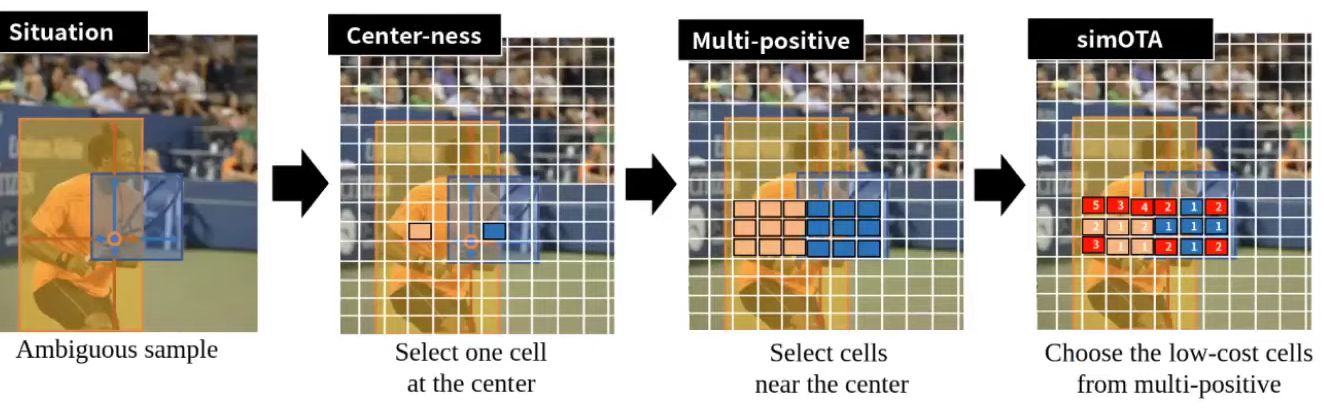
* Prediction 하고자 하는 값에 따라 Head를 나누는 **Decoupled Head** 방식을 사용하여 Detector를 End-to-End 방식으로 만들 수 있었다.
    > 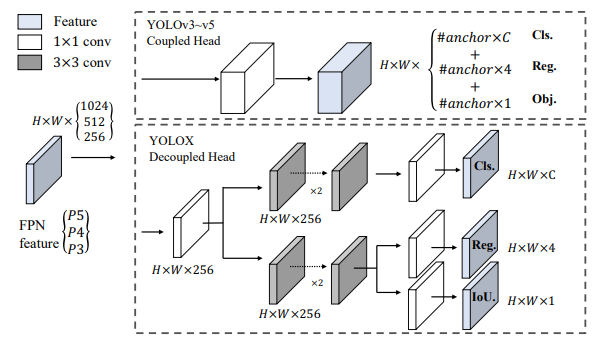
    > * Decoupled head를 적용하여 Class classification, BBox Regression, Objectness를 따로 예측
    > * 이때 Objectness는 물체가 있는지 없는지를 확인
    
    
* Strong data augmentation을 적용 
    >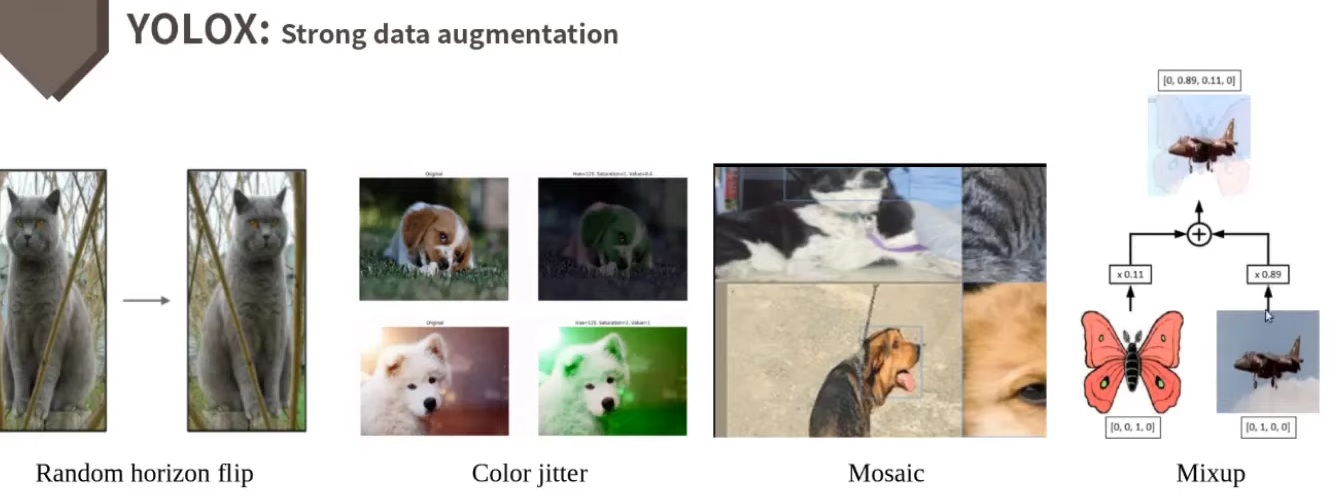

* GIoU Loss를 적용
    >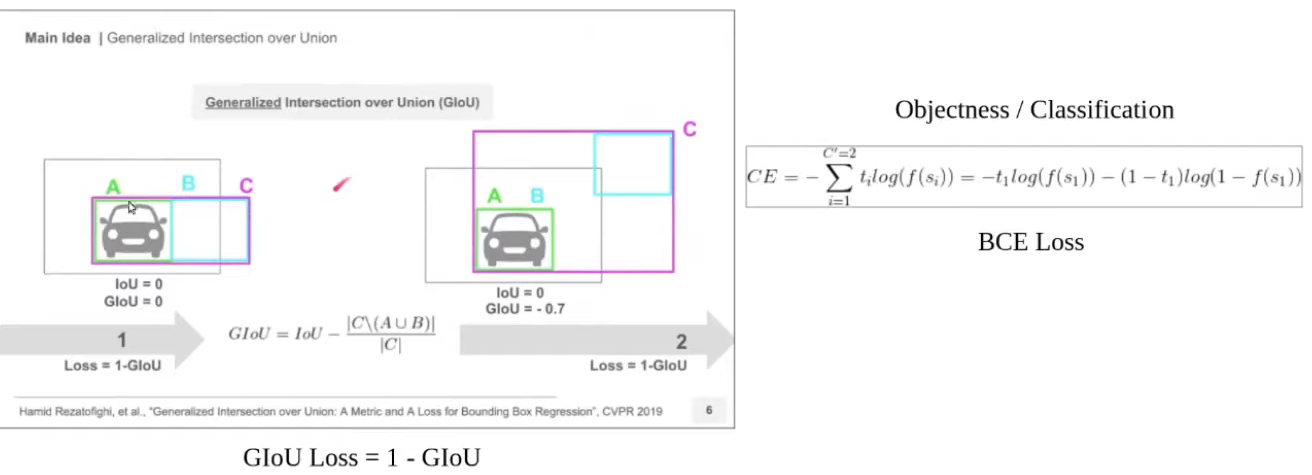
    >* 더 나쁜 BBox에 패널티를 주는 Loss이다.

### YOLOS ( You Only Look at One Sequence )

* YOLOS는 Transformer Encoder와 MLP Heads 만을 이용하여 2D Object detection을 수행했다.
* 하지만 YOLOS의 성능은 그렇게 좋지는 못하다.
* YOLOS의 모델 구조는 DETR과 Bipartite Loss를 합친 구조이다.
    >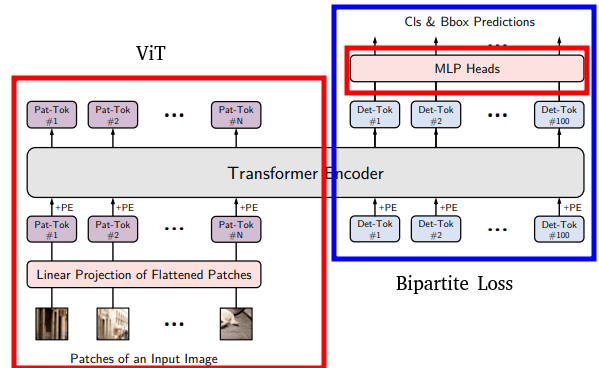

## SSD(Single Shot MultiBox Detector)

* SSD는 YOLOv1의 grid를 사용했을 때의 단점을 보완하는 테크닉을 제안합니다.

### Image Pyramid

* YOLOv1의 단점 중 하나인 Box 정보 (x, y, w, h)를 예측하기 위한 기본정보가 없기 때문에 넓은 BBox 분포를 모두 학습할 수 없다는 점을 개선하기 위해 Anchor Box를 제안하는 layer를 추가

    >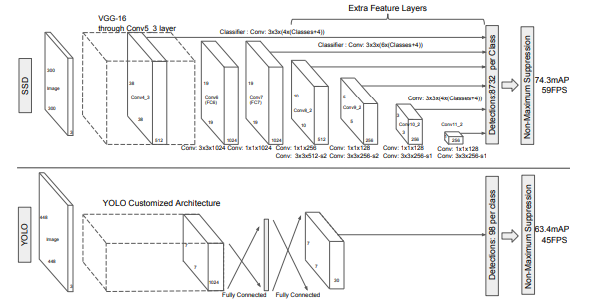

* SSD는 VGG16을 사용하여 Pooling layer를 거친 block을 하나의 image feature로 사용하여 다양한 크기의 feature map을 확인한다.
* 이때 각 feature map에서 bounding box를 찾을 Detector와 class를 분류하는 classifier를 통과하여 정보를 얻고 NMS를 통해 최종 detection 결과물을 얻는다.
    > 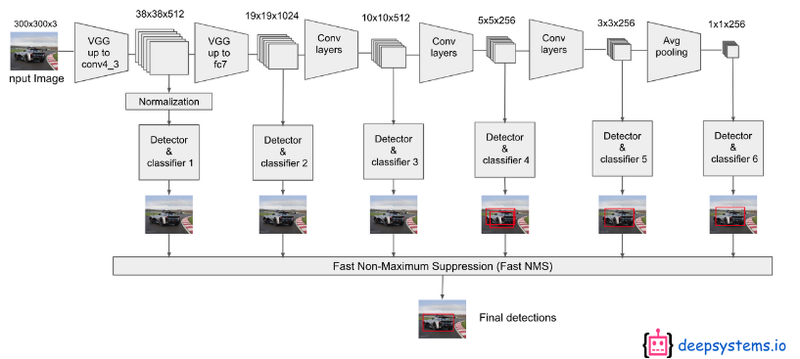

### Pre-defined Anchor Box

* SSD는 입력 이미지와 Ground Truth box로 학습합니다.
* Convolution 과정에서 default box를 설정하는데, 다른 크기의 feature map에서 각 객체마다 다른 비율의 default box를 4개씩 만든다. 각 default box에서 그와 대응되는 bounding box regression을 적용하여 box(x, y, w, h), confidence(물체의 유무)를 예측한다.
    > 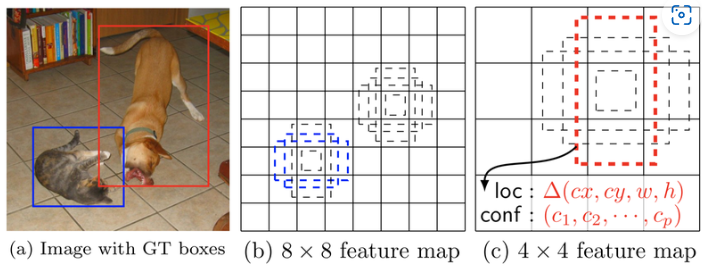
    > * 여기서 default box와 ground truth box를 비교하여 일정 thres 보다 비슷한 default box를 positive, 나머지는 negative로 설정한다.
    > * 위 그림에서는 작은 물체인 고양이는 8x8 feature map에서, 큰 물체인 개는 4x4 feature map에서 감지한 것을 볼 수 있다.
*  이렇게 각 레이어에서 feature map을 가져와 Object Detection을 수행한 결과를 모두 합하여 Localization Loss와 Confidecne Loss를 구하여 네트워크를 학습한다.

### Default box를 위한 Scale
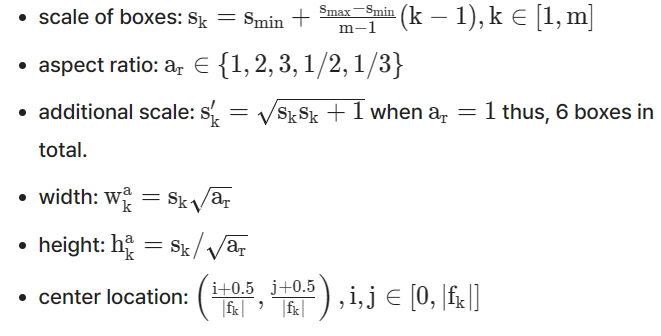
> 1. Scale of Boxes $s_k$ : 박스의 크기
> 2. Aspect ratio $a_r$ : 종횡비, 5개의 default box
> 3. Additional scale : 중심점에 정사각박스를 추가해 총 6개의 default box
> 4. 너비
> 5. 높이
> 6. 중심점
> 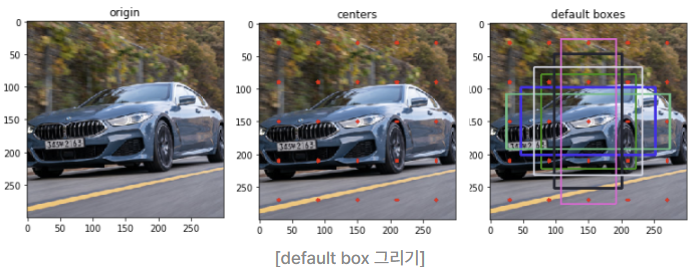

### SSD의 Loss와 Metric

* **Matching strategy** - 학습 전 ground truth와 default box가 IoU50이상을 Positive sample로 설정하여 모두 사용하면 학습을 단순화하여 더 높은 성능을 나타낸다.

* **Loss function**
    1. Objective Loss Function
    > 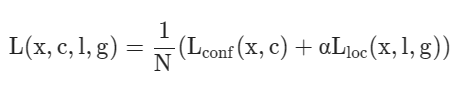
    > * Total Loss로 각 클래스 별로 예측한 값과 실제값 사이의 차이인 $L_{conf}$와 BBox regression 예측값과 실제값 사이의 차이인 $L_{loc}$를 더한 값
    2. Localization Loss Function
    > 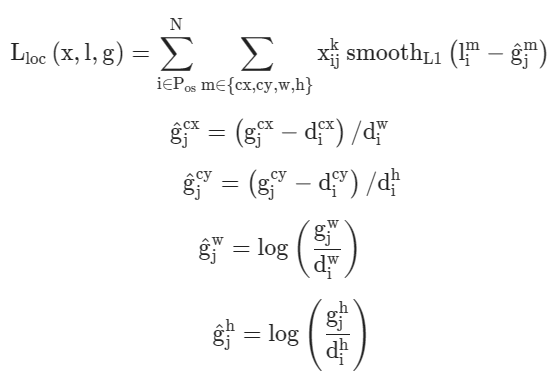
    > * 예측한 박스 $L$과 Ground truth box $g$사이 L1 Loss
    > * $\hat{g}_j$는 예측할 BBox의 x, y, w, h를 의미
    > * x, y 좌표는 절대값으로 default 박스의 너비 또는 높이로 나누어 정규화, 너비와 높이는 로그

    3. Confidence Loss Function
    > 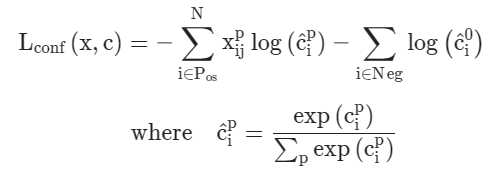
    > * 여러 클래스의 Confidence에 대한 Softmax Loss(CE)인 $c^p_i$
    > * 배경인지 아닌지를 나타내는 $\hat{c}^0_i$
    > * 최종 Loss는 위 둘의 합이다.

### Hard negative mining

* 대부분의 Default box는 배경인 Imbalanced class 문제가 있다.
* 이를 해결하기 위해 마지막 Class Loss에서는 default box를 high confidence 순으로 정렬하여 상위값을 이용한다.
* 이때 P:N 비율을 1:3으로 출력하여 최적화 속도를 높이고 학습이 안정적이게 된다.

## Face Detection SOTA

### TinaFace
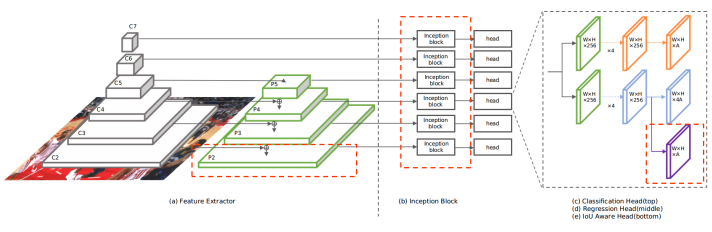
* Face Detection과 Object Detection은 다르지 않다는 주장
* ResNet50을 Backbone으로 사용 FCN, Decoupled Head를 사용

### RetinaFace
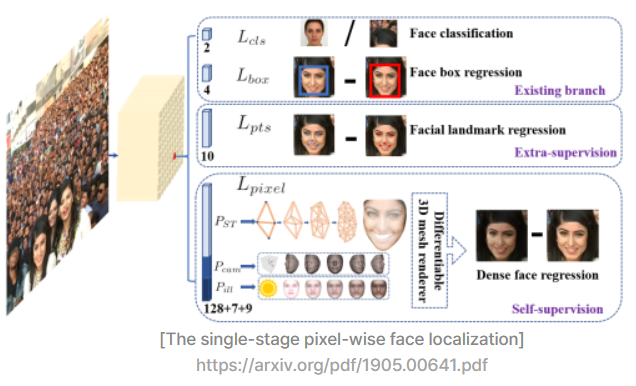
* 다양한 얼굴 크기에 대해 Pixel-wise face localization을 수행
* face score, face box, 5개의 얼굴 랜드마크, 3D face vaertices 를 예측

### DSFD (Dual Shot Face Detector)
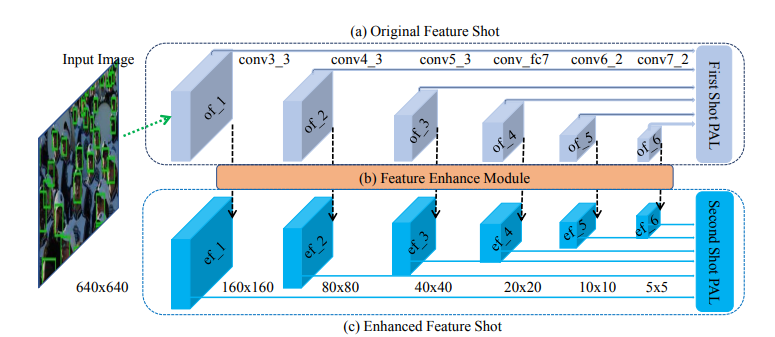
* Feature Enhance Module(FEM), Progressive Anchor Loss(PAL), Improved Anchor Matching(IAM)라는 기법을 사용해 성능을 높인 모델
* 위 3개의 기법을 Two-stream으로 디자인하여 DSFD라는 이름이 붙었다.

### S3FD (Single Shot Scale-invariant Face Detector)
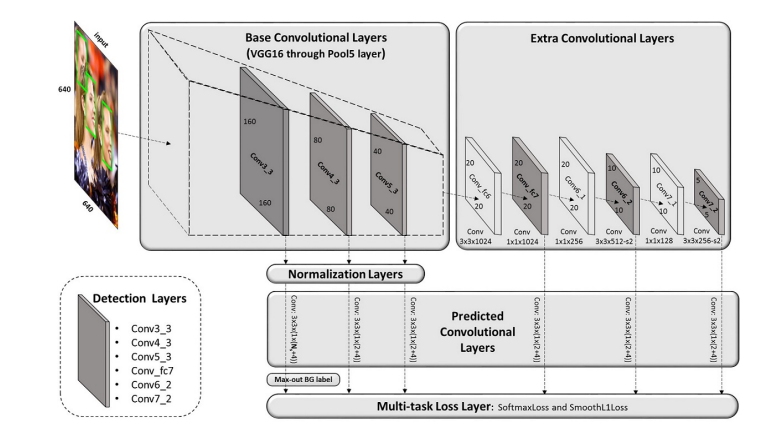
* 하나의 네트워크를 사용하여 다양한 얼굴 크기에 대해 face detection을 수행한다. 특히 작은 얼굴을 잘 찾는다.
* 다양한 크기의 얼굴을 잘 찾기위해 layer의 넓은 범위에 anchor를 촘촘히 배열하였고 anchor의 크기도 사람의 얼굴에 맞게 디자인했다.